In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import collections
from orderedset import OrderedSet

In [271]:
from latticegpm import LatticeGenotypePhenotypeMap
import latticegpm
from latticeproteins.conformations import Conformations
from latticeproteins.fitness import Fitness
from latticeproteins.evolution import AdaptiveWalk
from latticeproteins.sequences import RandomSequence

from gpmap.evolve.models import fixation
from gpmap.evolve.mc import monte_carlo, monte_carlo_metropolis_criterion
from gpmap.graph.paths import paths_and_probabilities
from gpmap.graph.paths import flux
from gpmap.graph import draw
from gpmap.utils import hamming_distance, find_differences

'GCYNWSDATGCCQMG', 'CCWNWLDAIMCCQMG'

In [272]:
from latticegpm.thermo import LatticeThermodynamics
from latticegpm.search import adaptive_walk

In [421]:
temperature = 1.0
length = 15

wildtype = "".join(RandomSequence(length))
c = Conformations(length, "database")
dGdependence = "fracfolded"

# Calculate the kth lowest conformations
k = 3
ncontacts = c.MaxContacts()
confs = np.array(c.UniqueConformations(ncontacts))
energies = np.empty(len(confs), dtype=float)
for i, conf in enumerate(confs):
    output = c.FoldSequence(wildtype, 1.0, target_conf=str(conf), loop_in_C=False)
    energies[i] = output[0]
    
sorted_e = np.argsort(energies)
two_states = confs[sorted_e[0:2]]
three_states = confs[sorted_e[0:3]]

In [422]:
#latticegpm.svg.Configuration(wildtype, three_states[0], font_size=8)

In [423]:
#latticegpm.svg.Configuration(wildtype, three_states[1], font_size=8)

In [424]:
#latticegpm.svg.Configuration(wildtype, three_states[2], font_size=8)

In [425]:
mutations = 5

wtlattice = LatticeThermodynamics(wildtype, three_states, temperature=temperature)
mutlattice = adaptive_walk(wtlattice, mutations)
mutant = mutlattice.sequence

color_sequence = list("k"*len(mutant))
for i in find_differences(wildtype, mutant):
    color_sequence[i] = "r"

In [426]:
# Construct a genotype-phenotype map
gpm_3state = LatticeGenotypePhenotypeMap.from_mutant(wildtype, mutant, c, temperature=temperature)
gpm_3state.phenotype_type = dGdependence
gpm_3state.set_partition_confs(three_states)

G_3state = gpm_3state.add_networkx()
G_3state.add_evolutionary_model(fixation)

# stuff
mapping = gpm_3state.map("genotypes", "indices")
s = mapping[wildtype]
t = mapping[mutant]

# Construct a genotype-phenotype map without an ensemble
gpm_2state = LatticeGenotypePhenotypeMap.from_mutant(wildtype, mutant, c, temperature=temperature)
gpm_2state.phenotype_type = dGdependence
gpm_2state.set_partition_confs(two_states)

G_2state = gpm_2state.add_networkx()
G_2state.add_evolutionary_model(fixation)

/Users/Zsailer/Documents/Research/projects/pkgs/gpmap/gpmap/evolve/models.py:13: RuntimeWarning: overflow encountered in exp
  denominator = 1 - np.exp(-N * sij)


Raise the temperature, to allow trajectories to pass.

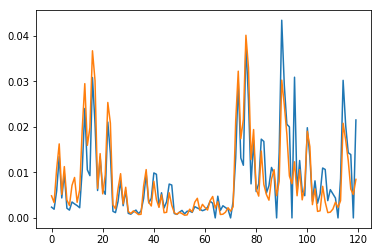

In [427]:
paths_3state, probs_3state = paths_and_probabilities(G_3state, s, t)
paths_2state, probs_2state = paths_and_probabilities(G_2state, s, t)
plt.plot(probs_3state)
plt.plot(probs_2state)

/Users/Zsailer/Documents/Research/projects/pkgs/gpmap/gpmap/evolve/models.py:13: RuntimeWarning: overflow encountered in exp
  denominator = 1 - np.exp(-N * sij)


(<matplotlib.figure.Figure at 0x15527fb00>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1557529b0>)

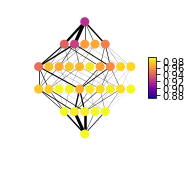

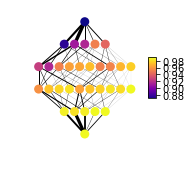

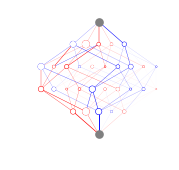

In [428]:
fluxes_3state = flux(G_3state, s, t, transition_model=fixation)
fluxes_2state = flux(G_2state, s, t, transition_model=fixation)

width=8

vmax = max([max(gpm_3state.phenotypes),max(gpm_2state.phenotypes)])
vmin = min([min(gpm_3state.phenotypes),min(gpm_2state.phenotypes)])
#print(round(vmax,2), round(vmin,2))
settings = dict(
    figsize=[2.5,2.5], 
    n_height=9, 
    n_width=9,
    n_linewidths=0,
    n_vmax=round(vmax,2),
    n_vmin=round(vmin,2),
    e_arrows=False, 
    l_alpha=0.0,
    n_colorbar=True
)  

fig, ax, pos = draw.network(G_2state, e_width = width*fluxes_2state, **settings)
#fig.savefig("../img/network-"+dataset+"-2nd-order.pdf", format="pdf")
fig, ax, pos = draw.network(G_3state, e_width = width*fluxes_3state, **settings)
#fig.savefig("../img/network-"+dataset+"-5th-order.pdf", format="pdf")

draw.diff(G_2state, G_3state, s, t)

In [429]:
from epistasis.models import EpistasisLinearRegression
from epistasis.plot import coefs, fraction_explained

/Users/Zsailer/Documents/Research/projects/pkgs/epistasis/epistasis/plot/fraction_explained.py:18: UserWarning: fx_vector does not add up to 1
  warnings.warn("fx_vector does not add up to 1")


(<matplotlib.figure.Figure at 0x1550ec278>,
 <matplotlib.axes._subplots.AxesSubplot at 0x155c7e320>)

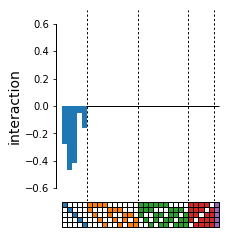

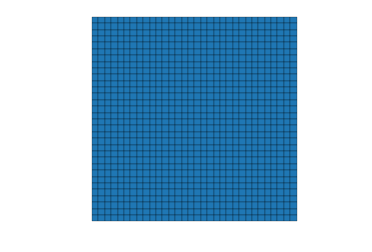

In [430]:
gpm_2state.phenotype_type = "stabilities"
model_2state = EpistasisLinearRegression.from_gpm(gpm_2state, order=0, model_type="global")
model_2state.fit()
fx = [model_2state.score()]
for i in range(1, gpm_2state.binary.length+1):
    model_2state = EpistasisLinearRegression.from_gpm(gpm_2state, order=i, model_type="global")
    model_2state.fit()
    score = model_2state.score() - sum(fx)
    fx.append(score)
coefs(model_2state.epistasis.values, model_2state.epistasis.labels, figsize=(3,4))
fraction_explained(fx[1:])

(<matplotlib.figure.Figure at 0x153c574e0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x156d4d048>)

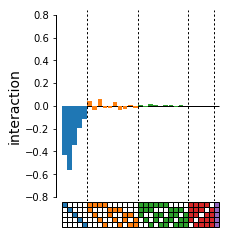

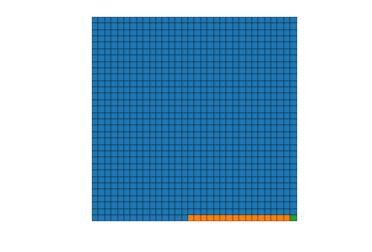

In [431]:
gpm_3state.phenotype_type = "stabilities"
model_3state = EpistasisLinearRegression.from_gpm(gpm_3state, order=0, model_type="global")
model_3state.fit()
fx = [model_3state.score()]
for i in range(1, gpm_3state.binary.length+1):
    model_3state = EpistasisLinearRegression.from_gpm(gpm_3state, order=i, model_type="global")
    model_3state.fit()
    score = model_3state.score() - sum(fx)
    fx.append(score)
coefs(model_3state.epistasis.values, model_3state.epistasis.labels, figsize=(3,4))
fraction_explained(fx[1:])